## Data Collection

In [2]:
# Importing Libraries

## "requests" allows us to make HTTP requests which we will use to get data from an API
import requests
# "pandas" is a software library written for the Python programming language for data manipulation and analysis.
import pandas as pd
# "numpy" is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import numpy as np
# "datetime" is a library that allows us to represent dates
import datetime

# Setting this option will print all collumns of a dataframe
pd.set_option('display.max_columns', None)
# Setting this option will print all of the data in a feature
pd.set_option('display.max_colwidth', None)

In [3]:
# Defining Helper functions that will help us use the API to Extract Information using identification numbers in the launch data

## From the "rocket" column, we want to learn the Booster's name

# Takes the dataset and uses the "rocket" column to call the API and append the data to the list
def getBoosterVersion(data):
    for x in data['rocket']:
       if x:
        response = requests.get("https://api.spacexdata.com/v4/rockets/"+str(x)).json()
        BoosterVersion.append(response['name'])

## From the "launchpad" column, we want to know the Name of the Launch Site being used, its Latitude, and its Longitude

# Takes the dataset and uses the "launchpad" column to call the API and append the data to the list
def getLaunchSite(data):
    for x in data['launchpad']:
       if x:
         response = requests.get("https://api.spacexdata.com/v4/launchpads/"+str(x)).json()
         Longitude.append(response['longitude'])
         Latitude.append(response['latitude'])
         LaunchSite.append(response['name'])
        
## From the "payload" column, we want to learn the mass of the payload and the orbit that it is going to

# Takes the dataset and uses the payloads column to call the API and append the data to the lists
def getPayloadData(data):
    for load in data['payloads']:
       if load:
        response = requests.get("https://api.spacexdata.com/v4/payloads/"+load).json()
        PayloadMass.append(response['mass_kg'])
        Orbit.append(response['orbit'])
        
## From the "cores" column, we want to learn:
### - The outcome of the landing
### - The type of the landing 
### - Number of flights with that core
### - Whether gridfins were used
### - Whether the core is reused
### - Wheter legs were used
### - The landing pad used
### - The block of the core which is a number used to seperate version of cores
### - The number of times this specific core has been reused
### - The serial of the core.

# Takes the dataset and uses the "cores" column to call the API and append the data to the lists
def getCoreData(data):
    for core in data['cores']:
            if core['core'] != None:
                response = requests.get("https://api.spacexdata.com/v4/cores/"+core['core']).json()
                Block.append(response['block'])
                ReusedCount.append(response['reuse_count'])
                Serial.append(response['serial'])
            else:
                Block.append(None)
                ReusedCount.append(None)
                Serial.append(None)
            Outcome.append(str(core['landing_success'])+' '+str(core['landing_type']))
            Flights.append(core['flight'])
            GridFins.append(core['gridfins'])
            Reused.append(core['reused'])
            Legs.append(core['legs'])
            LandingPad.append(core['landpad'])

In [4]:
# Now, we will Start Requesting Rocket Launch Data from SpaceX API with the following URL:

spacex_url="https://api.spacexdata.com/v4/launches/past"
response = requests.get(spacex_url)

## You may Convert it into a Dataframe: "r = pd.DataFrame(response)"

# Print the Content of the SpaceX Data Requested
# print(response.content)

In [5]:
# Request and Parse - to make the Requested JSON Results more Consistent - SpaceX Launch Data Using the GET Request

static_json_url='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/API_call_spacex_api.json'

response.status_code ## "200" is Status Response Code: Request was Successful

# Using "json_normalize" meethod to convert the JSON result into a Dataframe

r2 = requests.get(static_json_url)
r = r2.json()

data = pd.json_normalize(r) ## Converting JSON to a DataFrame

In [6]:
# We will now use the API again to get Information about the Launches using the IDs given for each launch. Specifically, we will be using columns "rocket", "payloads", "launchpad", and "cores"

# Lets take a subset of our dataframe keeping only the features we want and the flight number, and date_utc.
data = data[['rocket', 'payloads', 'launchpad', 'cores', 'flight_number', 'date_utc']]

# We will remove rows with multiple cores because those are falcon rockets with 2 extra rocket boosters and rows that have multiple payloads in a single rocket.
data = data[data['cores'].map(len)==1]
data = data[data['payloads'].map(len)==1]

# Since payloads and cores are lists of size 1 we will also extract the single value in the list and replace the feature.
data['cores'] = data['cores'].map(lambda x : x[0])
data['payloads'] = data['payloads'].map(lambda x : x[0])

# We also want to convert the date_utc to a datetime datatype and then extracting the date leaving the time
data['date'] = pd.to_datetime(data['date_utc']).dt.date

# Using the date we will restrict the dates of the launches
data = data[data['date'] <= datetime.date(2020, 11, 13)]

In [7]:
# The data from these Requests will be Stored in Lists and will be used to Create a new Dataframe

## Global Variables
BoosterVersion = []
PayloadMass = []
Orbit = []
LaunchSite = []
Outcome = []
Flights = []
GridFins = []
Reused = []
Legs = []
LandingPad = []
Block = []
ReusedCount = []
Serial = []
Longitude = []
Latitude = []

## Applying Respective Function Methods to get Data into the Lists

getBoosterVersion(data)
getLaunchSite(data)
getPayloadData(data)
getCoreData(data)

In [8]:
# Constructing the Dataset Using the Data Obtained - Combining the Columns into a Dictionary

launch_dict = {'FlightNumber': list(data['flight_number']),
'Date': list(data['date']),
'BoosterVersion':BoosterVersion,
'PayloadMass':PayloadMass,
'Orbit':Orbit,
'LaunchSite':LaunchSite,
'Outcome':Outcome,
'Flights':Flights,
'GridFins':GridFins,
'Reused':Reused,
'Legs':Legs,
'LandingPad':LandingPad,
'Block':Block,
'ReusedCount':ReusedCount,
'Serial':Serial,
'Longitude': Longitude,
'Latitude': Latitude}

# Creating a Pandas DataFrame from the Dictionary
ld = pd.DataFrame(launch_dict)

# Then, Filter the DataFrame to Only Include "Falcon 9" Launches
falc9 = ld[ld["BoosterVersion"]=="Falcon 9"]
falc9.loc[:,'FlightNumber'] = list(range(1, falc9.shape[0]+1)) ## Reset the "FlightNumber" Column After Removal of Some Values

# Check for Missing Values "falc9.isnull().sum()" and then Fill in the Missing Values in the "PayloadMass" with the Mean Values of that Column
falc9.isnull().sum()
falc9.replace(np.NaN, falc9["PayloadMass"].mean())

# Export the Resultant File to a CSV
falc9.isnull().sum()

FlightNumber       0
Date               0
BoosterVersion     0
PayloadMass        5
Orbit              0
LaunchSite         0
Outcome            0
Flights            0
GridFins           0
Reused             0
Legs               0
LandingPad        26
Block              0
ReusedCount        0
Serial             0
Longitude          0
Latitude           0
dtype: int64

## Web Scraping

In [9]:
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import numpy as np

import sys
import requests
from bs4 import BeautifulSoup
import re
import unicodedata
import pandas as pd
import numpy as np

# Helper Functions to Process Web-Scraped HTML Table

def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    out = ''.join([booster_version for i, booster_version in enumerate(table_cells.strings) if i % 2 == 0][0:-1])
    return out

def landing_status(table_cells):
    out = [i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass = unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass = mass[0:mass.find("kg")+2]
    else:
        new_mass = 0
    return new_mass

def extract_column_from_header(row):
    if row.br:
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

# Defining the URL and Getting Data From it, and then Creating a BeautifulSoup Object from it

static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
data = requests.get(static_url)
soup = BeautifulSoup(data.text, "html.parser")
## soup.title ### Printing out Title to Verify if the BeautifulSoup Object was Created Properly

# Extract all column/variable names from the HTML table header
html_tables = soup.find_all('table')

# Printing the Third Table
first_launch_table = html_tables[2]

# Let's print our Target Table - the Third Table - and Check its Content
target_table = html_tables[2]

# Extracting Column Names One-by-One

column_names = []

# Apply find_all() function with `th` element on first_launch_table
# Iterate each th element and apply the provided extract_column_from_header() to get a column name
# Append the Non-empty column name (`if name is not None and len(name) > 0`) into a list called column_names

# Assuming `first_launch_table` contains the HTML table
# Find all <th> elements
th_elements = first_launch_table.find_all('th')

# Iterate over each <th> element
for th in th_elements:
    # Extract column name using the provided function
    name = extract_column_from_header(th)
    # Check if the column name is not empty
    if name is not None and len(name) > 0:
        # Append the non-empty column name to column_names list
        column_names.append(name)

print(column_names) ## Printing Out Column Names to Verify if they were Received Properly

# Helper Functions to Process Web-Scraped HTML Table

def date_time(table_cells):
    return [data_time.strip() for data_time in list(table_cells.strings)][0:2]

def booster_version(table_cells):
    out = ''.join([booster_version for i, booster_version in enumerate(table_cells.strings) if i % 2 == 0][0:-1])
    return out

def landing_status(table_cells):
    out = [i for i in table_cells.strings][0]
    return out

def get_mass(table_cells):
    mass = unicodedata.normalize("NFKD", table_cells.text).strip()
    if mass:
        mass.find("kg")
        new_mass = mass[0:mass.find("kg")+2]
    else:
        new_mass = 0
    return new_mass

def extract_column_from_header(row):
    if row.br:
        row.br.extract()
    if row.a:
        row.a.extract()
    if row.sup:
        row.sup.extract()
        
    colunm_name = ' '.join(row.contents)
    
    if not(colunm_name.strip().isdigit()):
        colunm_name = colunm_name.strip()
        return colunm_name

# Defining the URL and Getting Data From it, and then Creating a BeautifulSoup Object from it

static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"
data = requests.get(static_url)
soup = BeautifulSoup(data.text, "html.parser")

# Extract all column/variable names from the HTML table header
html_tables = soup.find_all('table')
first_launch_table = html_tables[2]

# Extracting Column Names One-by-One
column_names = []
th_elements = first_launch_table.find_all('th')

for th in th_elements:
    name = extract_column_from_header(th)
    if name is not None and len(name) > 0:
        column_names.append(name)

# Create a DataFrame by Parsing the Launch_HTML Tables
launch_entries = []

# Extract each table 
for table_number, table in enumerate(soup.find_all('table', "wikitable plainrowheaders collapsible")):
    for rows in table.find_all("tr"):
        if rows.th:
            if rows.th.string:
                flight_number = rows.th.string.strip()
                flag = flight_number.isdigit()
        else:
            flag = False

        row = rows.find_all('td')
        if flag:
            datatimelist = date_time(row[0])
            date = datatimelist[0].strip(',')
            time = datatimelist[1]
            bv = booster_version(row[1])
            if not(bv):
                bv = row[1].a.string if row[1].a else None
            launch_site = row[2].a.string if row[2].a else None
            payload = row[3].a.string if row[3].a else None
            payload_mass = get_mass(row[4])
            orbit = row[5].a.string if row[5].a else None
            customer = row[6].a.string if row[6].a else None
            launch_outcome = list(row[7].strings)[0] if row[7] else None
            booster_landing = landing_status(row[8]) if row[8] else None
            
            launch_dict = {
                'Flight No.': flight_number,
                'Launch site': launch_site,
                'Payload': payload,
                'Payload mass': payload_mass,
                'Orbit': orbit,
                'Customer': customer,
                'Launch outcome': launch_outcome,
                'Version Booster': bv,
                'Booster landing': booster_landing,
                'Date': date,
                'Time': time
            }
            launch_entries.append(launch_dict)

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(launch_entries)
df

# Filtering DataFrame for Falcon 9
# falc9 = df[df["Version Booster"] == "Falcon 9"]
# falc9.loc[:, 'Flight No.'] = list(range(1, falc9.shape[0] + 1))

# # Checking for Missing Values and Filling them with Mean Values
# falc9["Payload mass"] = falc9["Payload mass"].replace(np.nan, falc9["Payload mass"].astype(float).mean())

# # Export the Resultant File to a CSV
# falc9.to_csv("falcon9_launches.csv", index=False)

# # Print the DataFrame to verify
# print(falc9.head())

['Flight No.', 'Date and time ( )', 'Launch site', 'Payload', 'Payload mass', 'Orbit', 'Customer', 'Launch outcome']


,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10
...,...,...,...,...,...,...,...,...,...,...,...
116,117,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1051.10,Success,9 May 2021,06:42
117,118,KSC,Starlink,"~14,000 kg",LEO,SpaceX,Success\n,F9 B5B1058.8,Success,15 May 2021,22:56
118,119,CCSFS,Starlink,"15,600 kg",LEO,SpaceX,Success\n,F9 B5B1063.2,Success,26 May 2021,18:59
119,120,KSC,SpaceX CRS-22,"3,328 kg",LEO,NASA,Success\n,F9 B5B1067.1,Success,3 June 2021,17:29


In [10]:
# Define the URL of the webpage
static_url = "https://en.wikipedia.org/w/index.php?title=List_of_Falcon_9_and_Falcon_Heavy_launches&oldid=1027686922"

# Send a GET request to the URL
response = requests.get(static_url)

# Parse the HTML content of the webpage
soup = BeautifulSoup(response.text, "html.parser")

# Store the parsed HTML content in the 'data' object
data = soup
# data

## Data Wrangling

In [168]:
# Assuming df is your DataFrame loaded with the appropriate data

# Identify and Calculate the Percentage of Missing Values in Each Attribute
missing_values_percent = df.isnull().sum() / len(df) * 100
print("Percentage of Missing Values:\n", missing_values_percent)

# Identify Which Columns are Numerical or Categorical
print("Data Types of Columns:\n", df.dtypes)

# Calculating the Number of Launches on Each Site
launch_site_counts = df["Launch site"].value_counts()
print("Number of Launches on Each Site:\n", launch_site_counts)

# Calculating the Number and Occurrence of Each Orbit
orbit_counts = df["Orbit"].value_counts()
print("Number and Occurrence of Each Orbit:\n", orbit_counts)

# Calculating the Number and Occurrence of Mission Outcomes
landing_outcomes = df["Launch outcome"].value_counts()
print("Mission Outcomes:\n", landing_outcomes)

# Inspecting the unique outcomes
print("Unique Mission Outcomes:\n", landing_outcomes.keys())

# Dynamically determine bad outcome indices based on the actual number of unique outcomes
bad_outcome_indices = [i for i in range(len(landing_outcomes)) if 'failure' in landing_outcomes.keys()[i].lower()]

# Ensure we don't go out of bounds
bad_outcomes = set(landing_outcomes.keys()[bad_outcome_indices])
print("Bad Outcomes:\n", bad_outcomes)

# Create a function to map outcomes to binary values
def map_outcome(outcome):
    if outcome in bad_outcomes:
        return 0
    else:
        return 1

# Apply the function to the "Launch outcome" column and assign it to "landing_class"
df['landing_class'] = df['Launch outcome'].apply(map_outcome)

# Checking the Dataset with the New Stuff Added in, Now
print("Dataset Head with New Column:\n", df.head(8))

# Determining the Success Rate of Rocket Landings
success_rate = df["landing_class"].mean()
print("Success Rate of Rocket Landings:", success_rate)

# Exporting it to a CSV File for Future Usage
df.to_csv("/Users/alijazibrizvi/Downloads/dataset2.csv", index=False)

Percentage of Missing Values:
 Flight No.         0.000000
Launch site        0.000000
Payload            0.000000
Payload mass       0.000000
Orbit              0.000000
Customer           1.652893
Launch outcome     0.000000
Version Booster    0.000000
Booster landing    0.000000
Date               0.000000
Time               0.000000
landing_class      0.000000
dtype: float64
Data Types of Columns:
 Flight No.          int64
Launch site        object
Payload            object
Payload mass       object
Orbit              object
Customer           object
Launch outcome     object
Version Booster    object
Booster landing    object
Date               object
Time               object
landing_class       int64
dtype: object
Number of Launches on Each Site:
 Launch site
CCAFS             40
KSC               33
Cape Canaveral    20
VAFB              16
CCSFS             12
Name: count, dtype: int64
Number and Occurrence of Each Orbit:
 Orbit
LEO            67
GTO            33
Polar      

In [125]:
# The Magic SQL Query, in Python Form:

max_payload_mass = df['PAYLOAD_MASS__KG_'].max()

# Get the names of Booster Versions that have carried the maximum payload mass
booster_versions = df[df['PAYLOAD_MASS__KG_'] == max_payload_mass]['Booster_Version'].unique()

# Display the results
print("Booster Versions that have carried the maximum payload mass:")
for booster in booster_versions:
    print(booster)

Booster Versions that have carried the maximum payload mass:
F9 B5 B1048.4
F9 B5 B1049.4
F9 B5 B1051.3
F9 B5 B1056.4
F9 B5 B1048.5
F9 B5 B1051.4
F9 B5 B1049.5
F9 B5 B1060.2 
F9 B5 B1058.3 
F9 B5 B1051.6
F9 B5 B1060.3
F9 B5 B1049.7 


### EDA Using SQL

In [ ]:
# Using pip
!pip install ipython-sql

# Using conda
!conda install -c conda-forge ipython-sql

In [ ]:
%load_ext sql

import csv, sqlite3

con = sqlite3.connect("my_data1.db")
cur = con.cursor()

df = pd.read_csv("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv")
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False,method="multi")

# # Remove Blank Rows from the Table
%sql CREATE TABLE SPACEXTABLE as SELECT * FROM SPACEXTBL WHERE Date is not NULL

# # Listing the Total Number of Successful & Failed Mission Outcomes (Among Other Tasks of EDA)
%sql SELECT "Mission_Outcome", COUNT(*) AS "Total_Count" \
FROM SPACEXTBL \
WHERE "Mission_Outcome" LIKE 'Failure%' OR "Mission_Outcome" LIKE 'Success%' \
GROUP BY Mission_Outcome

# Using a Subquery to List the Names of Booster_Versions who have carried the Maximum Payload Mass
%sql SELECT DISTINCT "Booster_Version" \
FROM SPACEXTBL \
WHERE "PAYLOAD_MASS_KG_" = (SELECT MAX("PAYLOAD_MASS_KG_") FROM SPACEXTBL)

In [ ]:
%sql SELECT "Launch site" \
FROM SPACEXTBL \
WHERE "Launch site" LIKE 'CCA%'

In [189]:
import pandas as pd
import sqlite3

# Load data
df = pd.read_csv("/Users/alijazibrizvi/Downloads/dataset2.csv")

# Connect to SQLite database (or create it)
con = sqlite3.connect("spacex_data.db")
cur = con.cursor()

# Write the data to the SQL database
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False)

# Define the query to list failed landing outcomes in drone ship for the year 2015
query = """
SELECT 
    "Booster_Version", 
    "Launch_Site", 
    "Landing_Outcome" 
FROM 
    SPACEXTBL 
WHERE 
    "Landing_Outcome" LIKE 'Failure%' 
    AND strftime('%Y', "Date") = '2015';
"""

# Execute the query
failed_landings_2015 = pd.read_sql(query, con)

# Display the results
print(failed_landings_2015)

Empty DataFrame
Columns: ["Booster_Version", "Launch_Site", "Landing_Outcome"]
Index: []


In [133]:
# Convert the Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter the data based on the date range
start_date = '2010-06-04'
end_date = '2017-03-20'
filtered_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]

# Group by landing outcome and count occurrences
landing_outcomes_count = filtered_df['Landing_Outcome'].value_counts()

# Sort the counts in descending order
sorted_landing_outcomes = landing_outcomes_count.sort_values(ascending=False)

# Display the results
print(sorted_landing_outcomes)

Landing_Outcome
No attempt                10
Failure (drone ship)       5
Success (drone ship)       5
Controlled (ocean)         3
Success (ground pad)       3
Failure (parachute)        2
Uncontrolled (ocean)       2
Precluded (drone ship)     1
Name: count, dtype: int64


In [135]:
# Filter the data
filtered_df = df[(df['Landing_Outcome'] == 'Success (drone ship)') &
                 (df['PAYLOAD_MASS__KG_'] > 4000) &
                 (df['PAYLOAD_MASS__KG_'] < 6000)]

# Select the booster names
booster_names = filtered_df['Booster_Version'].unique()

# Display the results
print(booster_names)

['F9 FT B1022' 'F9 FT B1026' 'F9 FT  B1021.2' 'F9 FT  B1031.2']


In [147]:
# Filter the DataFrame for successful landings on ground pads
successful_ground_pad_landings = df[(df['Launch outcome'] == 'Success') & (df['Booster landing'] == 'Success')]

# Extract the dates of successful ground pad landings
successful_ground_pad_dates = successful_ground_pad_landings['Date']

# Find the date of the first successful landing on a ground pad
first_successful_ground_pad_date = successful_ground_pad_dates.min()

print("Date of the first successful landing on a ground pad:", first_successful_ground_pad_date)

Date of the first successful landing on a ground pad: 10 September 2018


In [186]:
# Filter the DataFrame for rows where the 'Customer' column contains 'NASA' and remove any missing values in the 'Payload mass' column
nasa_payloads = df[df['Customer'].str.contains('NASA', na=False) & df['Payload mass'].notnull()]

# Convert payload mass values to numeric (remove 'kg' and any commas)
nasa_payloads['Payload mass'] = nasa_payloads['Payload mass'].str.replace(' kg', '').str.replace(',', '')

# Convert the 'Payload mass' column to numeric datatype
nasa_payloads['Payload mass'] = pd.to_numeric(nasa_payloads['Payload mass'], errors='coerce')

# Calculate the total payload carried by boosters from NASA
total_payload_nasa = nasa_payloads['Payload mass'].sum()

print("Total payload carried by boosters from NASA:", total_payload_nasa, "kg")

Total payload carried by boosters from NASA: 99208.0 kg


/var/folders/j3/3j69h7bd37v9q0182sm6scrh0000gn/T/ipykernel_16340/1119584736.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nasa_payloads['Payload mass'] = nasa_payloads['Payload mass'].str.replace(' kg', '').str.replace(',', '')
/var/folders/j3/3j69h7bd37v9q0182sm6scrh0000gn/T/ipykernel_16340/1119584736.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nasa_payloads['Payload mass'] = pd.to_numeric(nasa_payloads['Payload mass'], errors='coerce')


In [188]:
# Filter the DataFrame for rows where the 'Launch site' column starts with 'CCA'
cca_launches = df[df['Launch site'].str.startswith('CCA', na=False)]

# Select the first 5 records
cca_launches_sample = cca_launches.head(5)

# Display the result
cca_launches_sample

,Flight No.,Launch site,Payload,Payload mass,Orbit,Customer,Launch outcome,Version Booster,Booster landing,Date,Time,landing_class
0,1,CCAFS,Dragon Spacecraft Qualification Unit,0,LEO,SpaceX,Success\n,F9 v1.0B0003.1,Failure,4 June 2010,18:45,1
1,2,CCAFS,Dragon,0,LEO,NASA,Success,F9 v1.0B0004.1,Failure,8 December 2010,15:43,1
2,3,CCAFS,Dragon,525 kg,LEO,NASA,Success,F9 v1.0B0005.1,No attempt\n,22 May 2012,07:44,1
3,4,CCAFS,SpaceX CRS-1,"4,700 kg",LEO,NASA,Success\n,F9 v1.0B0006.1,No attempt,8 October 2012,00:35,1
4,5,CCAFS,SpaceX CRS-2,"4,877 kg",LEO,NASA,Success\n,F9 v1.0B0007.1,No attempt\n,1 March 2013,15:10,1


### EDA with Visualization

/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


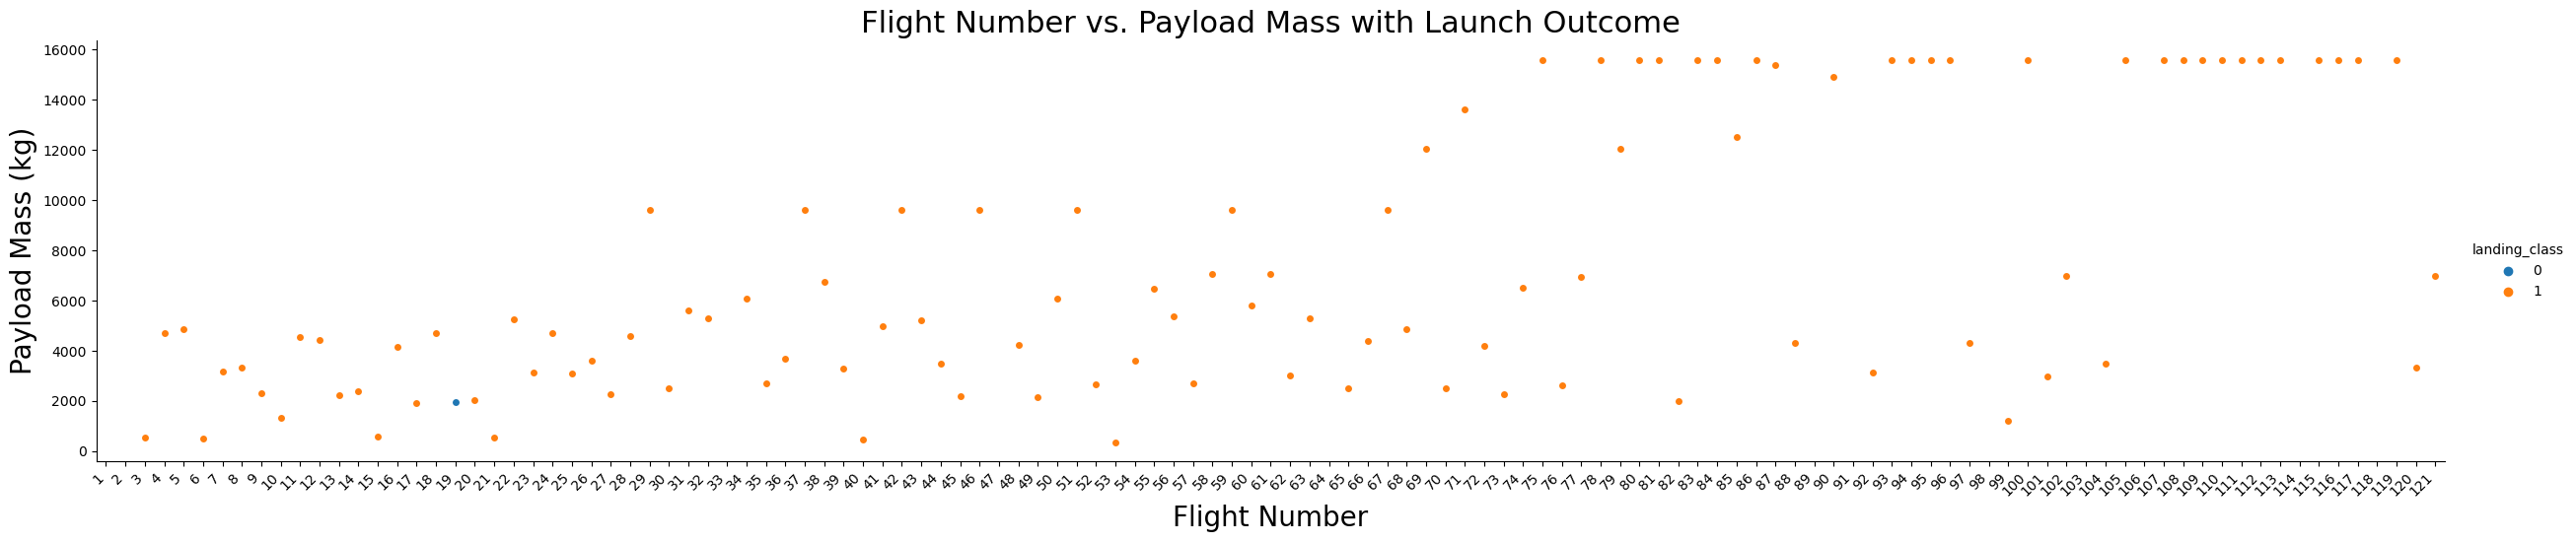

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Clean the "Payload mass" column by removing commas and the "kg" unit, then convert to numeric
# Use errors='coerce' to handle non-numeric values by converting them to NaN
# df['Payload mass'] = df['Payload mass'].str.replace(',', '').str.replace(' kg', '').apply(pd.to_numeric, errors='coerce')

# Convert 'Flight No.' column to string format
df['Flight No.'] = df['Flight No.'].astype(str)

# Plotting "Flight Number" vs. "Payload Mass" to Overlay the Outcome of the Launch
g = sns.catplot(y="Payload mass", x="Flight No.", hue="landing_class", data=df, aspect=5, kind="strip")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Payload Mass (kg)", fontsize=20)
plt.title("Flight Number vs. Payload Mass with Launch Outcome", fontsize=22)
plt.show()

# Notes:
# - "Class" = 0 or 1; Failed or Successful
# - Create more such graphs for other variables as needed

/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


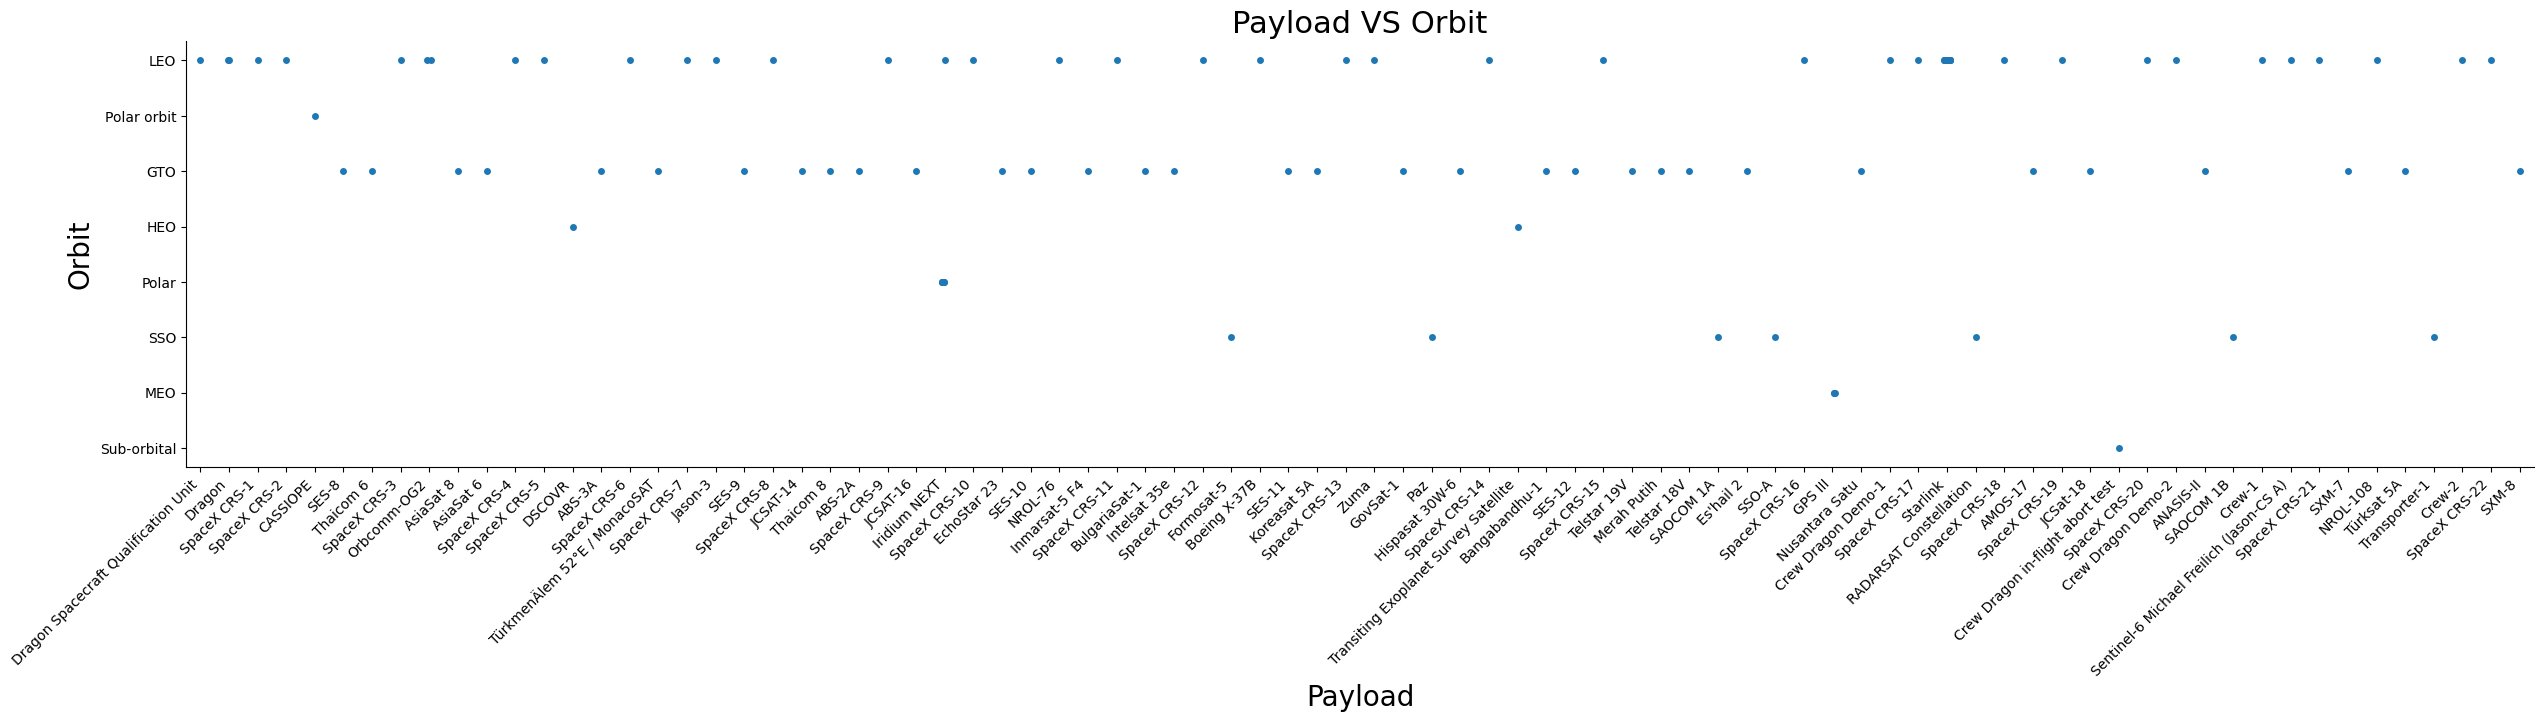

In [91]:
g = sns.catplot(y="Orbit", x="Payload", data=df, aspect=5, kind="strip")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.xlabel("Payload", fontsize=20)
plt.ylabel("Orbit", fontsize=20)
plt.title("Payload VS Orbit", fontsize=22)
plt.show()

/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


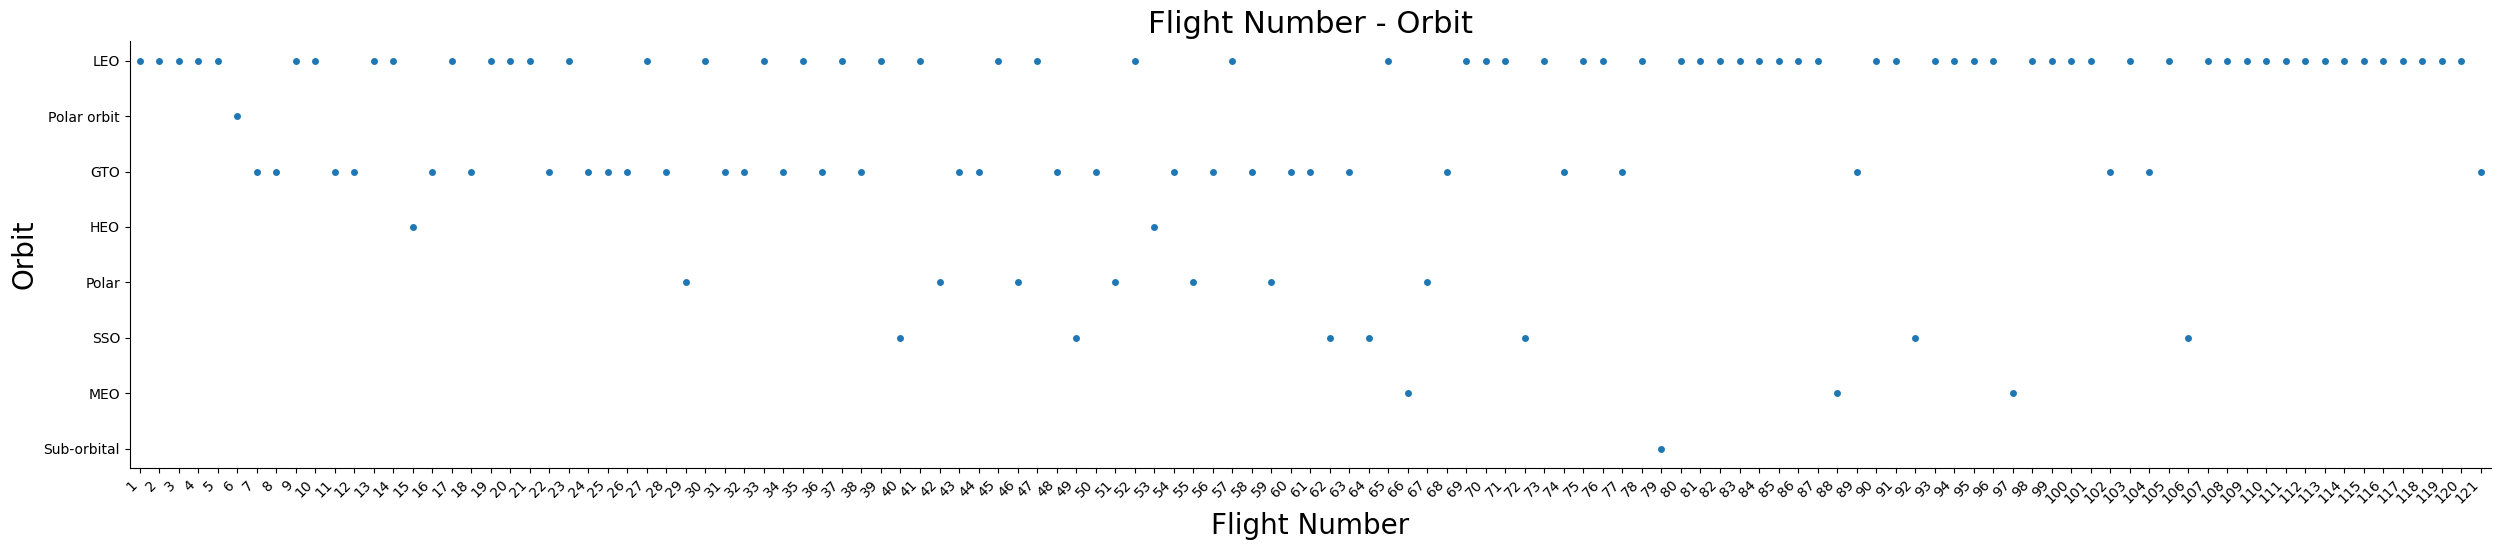

In [93]:
g = sns.catplot(y="Orbit", x="Flight No.", data=df, aspect=5, kind="strip")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Orbit", fontsize=20)
plt.title("Flight Number - Orbit", fontsize=22)
plt.show()

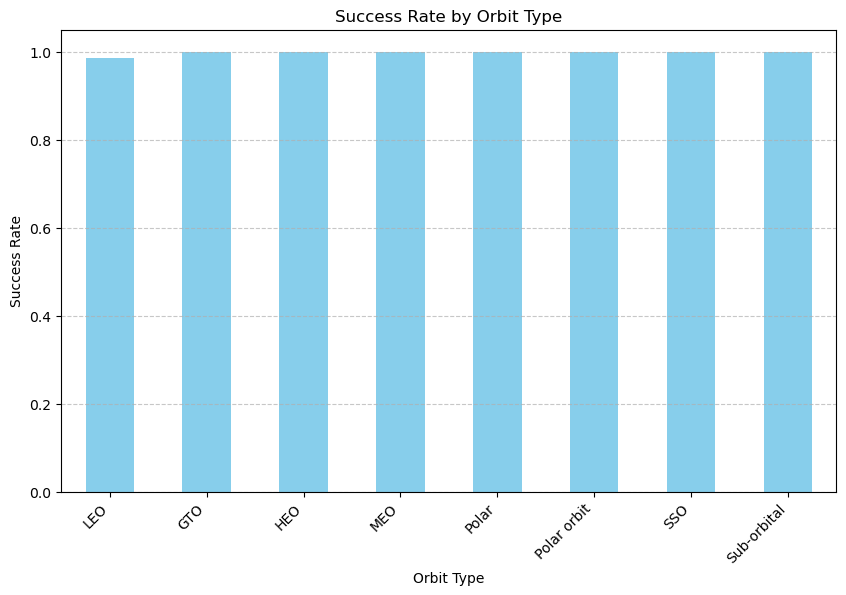

In [100]:
# Success Rate by Orbit Type

df['landing_class'] = df['Launch outcome'].apply(map_outcome)

# Group the data by Orbit and calculate success rate for each orbit type
orbit_success_rate = df.groupby('Orbit')['landing_class'].mean().sort_values()

# Plotting the success rates for each orbit type
plt.figure(figsize=(10, 6))
orbit_success_rate.plot(kind='bar', color='skyblue')
plt.title('Success Rate by Orbit Type')
plt.xlabel('Orbit Type')
plt.ylabel('Success Rate')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


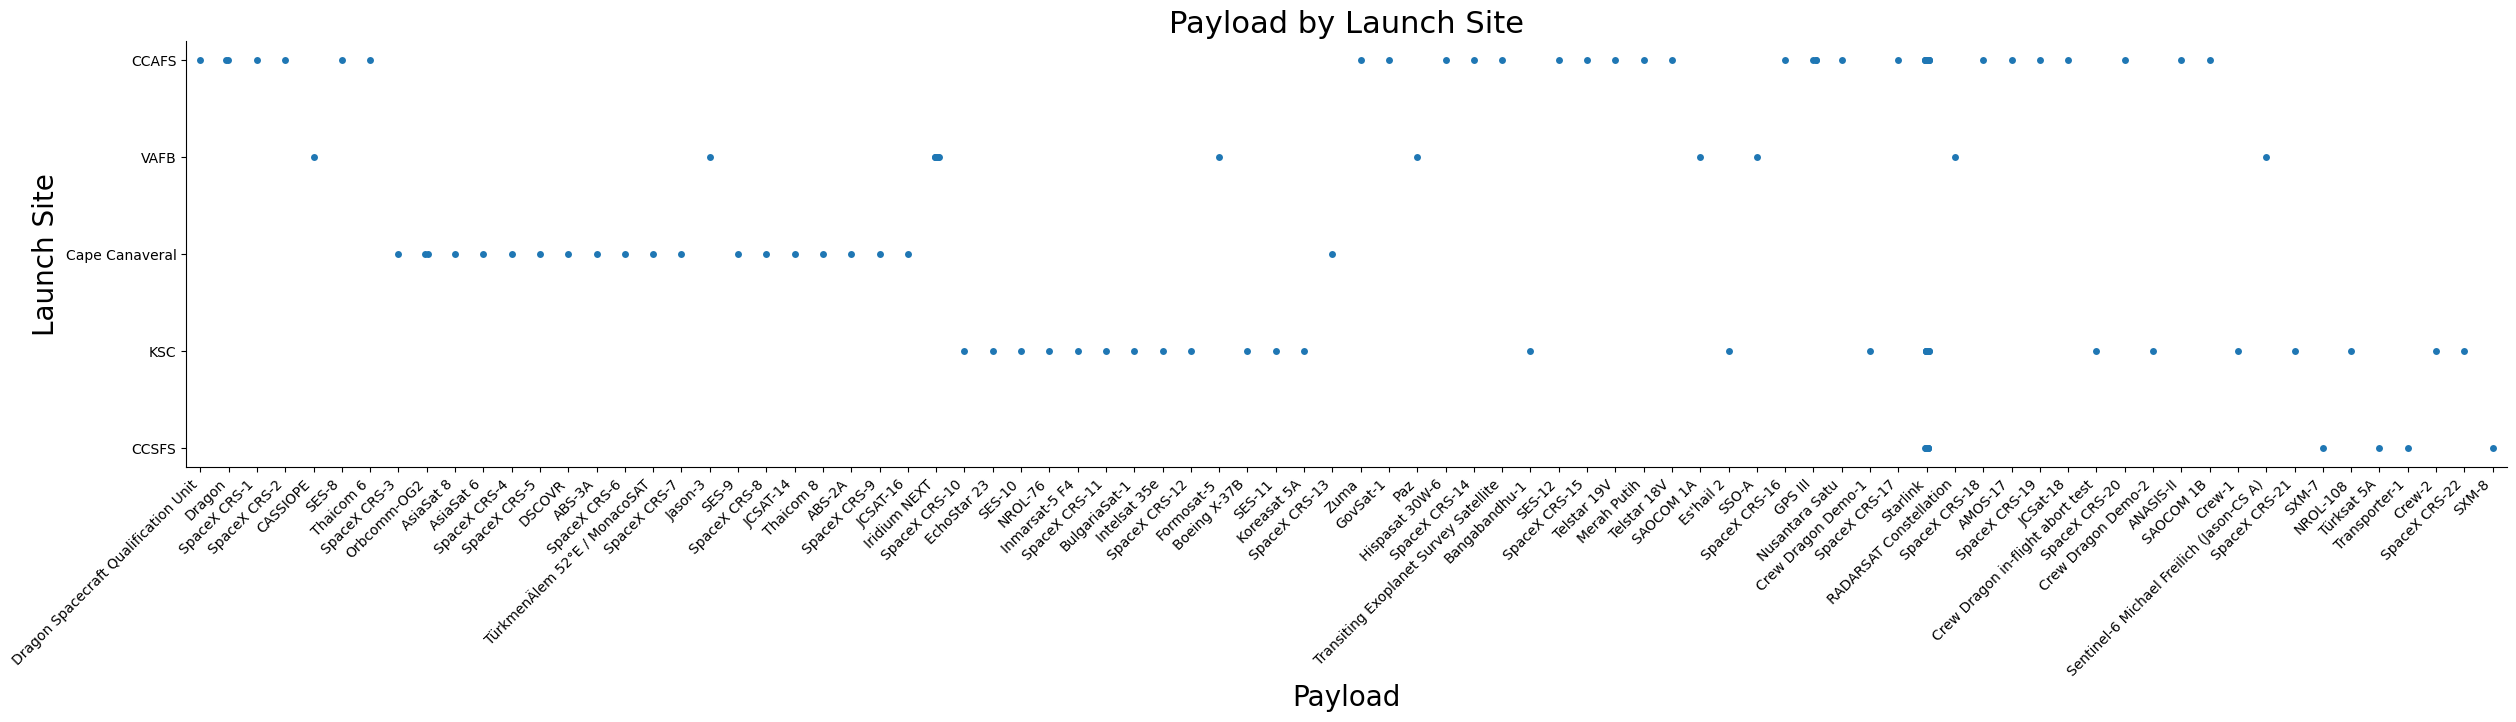

In [102]:
g = sns.catplot(y="Launch site", x="Payload", data=df, aspect=5, kind="strip")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.xlabel("Payload", fontsize=20)
plt.ylabel("Launch Site", fontsize=20)
plt.title("Payload by Launch Site", fontsize=22)
plt.show()

/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


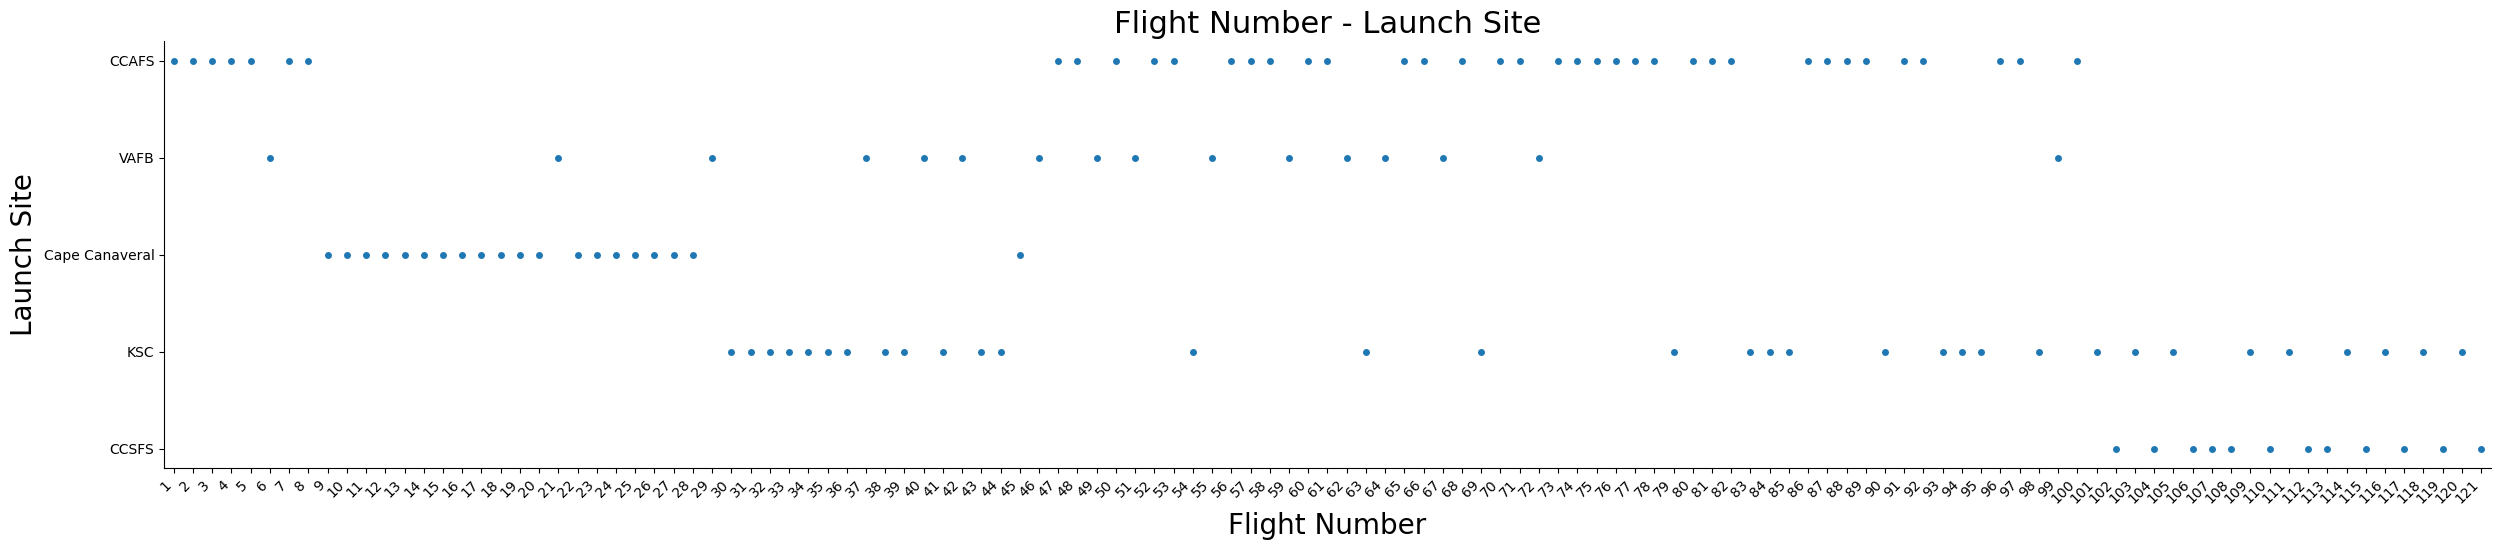

In [104]:
g = sns.catplot(y="Launch site", x="Flight No.", data=df, aspect=5, kind="strip")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.xlabel("Flight Number", fontsize=20)
plt.ylabel("Launch Site", fontsize=20)
plt.title("Flight Number - Launch Site", fontsize=22)
plt.show()

In [ ]:
# Plotting a Line Chart with x-axis to be Year and y-axis to be Average Success Rate: Average Launch Success Trend over the Years

# A Function to Extract Years from the "Date" Column Values 
year=[]
def Extract_year():
    for i in df["Date"]:
        year.append(i.split("-")[0])
    return year
Extract_year()
df['Date'] = year

# Then, Plotting the Line Chart
successrates = df.groupby('Date')["Class"].mean()

plt.plot(successrates.index, successrates.values)
plt.title("Success Rates of Launches Over the Years")
plt.xlabel("Year")
plt.ylabel("Success Rate")
plt.show()

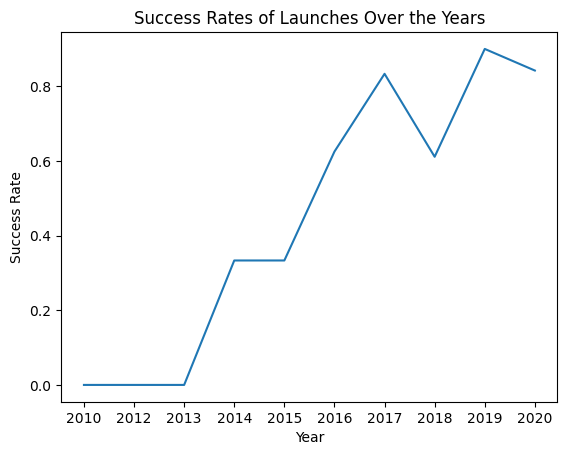

### Features Engineering

In [ ]:
# Selecting the Features that will be Used in Success Prediction in the Future

features = df[['Flight No.', 'Launch site', 'Payload', 'Payload mass', 'Orbit',
       'Customer', 'Launch outcome', 'Version Booster', 'Booster landing',
       'Date', 'Time', 'landing_class']]

# Applying OneHotEncoder on the Categorical Columns
features_one_hot = pd.get_dummies(features[["Orbit", "Launch site", "LandingPad", "Serial"]])

# Casting the Newly Numerical DataFrame^ as Float Values
features_one_hot.astype("float64")

## (Merging this to the Overall Features DataFrame)
### (dfnew = pd.concat([features, features_one_hot], axis=1))

## Interactive Visual Analytics & Dashboard

In [191]:
!pip install folium

  Obtaining dependency information for folium from https://files.pythonhosted.org/packages/b9/98/9ba4b9d2d07dd32765ddb4e4c189dcbdd7dca4d5a735e2e4ea756f40c36b/folium-0.16.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for branca>=0.6.0 from https://files.pythonhosted.org/packages/75/ca/6074ab4a04dd1a503201c18091b3426f3709670115fae316907a97f98d75/branca-0.7.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 1.9 MB/s eta 0:00:00 0:00:01


In [193]:
import folium
from folium.plugins import MarkerCluster, MousePosition
from folium.features import DivIcon
import pandas as pd
import requests
import io

# URL of the CSV file
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'

# Download the CSV file
response = requests.get(URL)
spacex_df = pd.read_csv(io.StringIO(response.text))

# Extract the Coordinates for each Site
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long']]

# Create a Folium Map object with the Start Location as NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

# Add Marker for each Launch Site
for _, site in launch_sites_df.iterrows():
    folium.Marker(
        location=[site['Lat'], site['Long']],
        popup=site['Launch Site'],
        icon=folium.Icon(icon='rocket', color='blue')
    ).add_to(site_map)

# Display the Map
site_map

In [194]:
# Using "folium.Circle" to Add a Highlighted Circle Area with a Text label on a Specific Coordinate

# Creating a Blue Circle at NASA Johnson Space Center's Coordinate with a Popup label Showing its Name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a Blue Circle at NASA Johnson Space Center's Coordinate with a Icon Showing its Name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an Icon as a Text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='<div style="font-size: 12; color:#d35400;"><b>%s</b></div>' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

# Adding in a Circle Label for Each Launch Site

## Loop through Each Launch Site
for index, site in launch_sites_df.iterrows():
    # Create a Circle for the Launch Site
    circle = folium.Circle(
        location=[site['Lat'], site['Long']],  # Use Latitude and Longitude from the DataFrame
        radius=1000,
        color='red',
        fill=True
    ).add_child(folium.Popup(site['Launch Site']))

    ## Create a Marker for the Launch Site
    marker = folium.map.Marker(
        location=[site['Lat'], site['Long']],  # Use Latitude and Longitude from the DataFrame
        icon=folium.DivIcon(
            icon_size=(20, 20),
            icon_anchor=(0, 0),
            html=f'<div style="font-size: 12; color:#d35400;"><b>{site["Launch Site"]}</b></div>'
        )
    )

    ## Add the Circle and Marker to the Map
    site_map.add_child(circle)
    site_map.add_child(marker)

site_map 

## And Then we Moved on to Create a Plotly Dash Interactive Dashboard

In [246]:
import folium
from folium.plugins import MarkerCluster, MousePosition
from folium.features import DivIcon
import pandas as pd
import requests
import io

# URL of the CSV file
URL = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv'

# Download the CSV file
response = requests.get(URL)
spacex_df = pd.read_csv(io.StringIO(response.text))

# Extract the Coordinates for each Site
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long', 'class']]

# Create a Folium Map object with the Start Location as NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

# Initialize MarkerCluster
marker_cluster = MarkerCluster().add_to(site_map)

# Define marker Colors based on Launch Outcomes
outcome_colors = {
    'Success': 'green',
    'Failure': 'red',
    'Partial Failure': 'orange',
    'Prelaunch Failure': 'gray'
}

# Add Marker for each Launch Site with Color-Labeled Launch Outcomes
for _, site in launch_sites_df.iterrows():
    outcome = site['class']
    color = outcome_colors.get(outcome, 'blue')  # Default Color for Unknown Outcomes
    folium.Marker(
        location=[site['Lat'], site['Long']],
        popup=site['Launch Site'],
        icon=folium.Icon(icon='rocket', color=color)
    ).add_to(marker_cluster)

# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
    
# Display the Map
site_map

In [251]:
from math import radians, sin, cos, sqrt, atan2

def calculate_distance(coord1, coord2):
    """
    Calculate the distance between two sets of coordinates using the Haversine formula.
    
    Parameters:
        coord1 (list): List containing the latitude and longitude of the first point in decimal degrees.
        coord2 (list): List containing the latitude and longitude of the second point in decimal degrees.
        
    Returns:
        float: The distance between the two points in kilometers.
    """
    # Radius of the Earth in kilometers
    R = 6371.0
    
    # Convert latitude and longitude from degrees to radians
    lat1 = radians(coord1[0])
    lon1 = radians(coord1[1])
    lat2 = radians(coord2[0])
    lon2 = radians(coord2[1])
    
    # Calculate the change in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Apply the Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    
    return distance

# Define Additional Points of Interest (railway, highway, coastline)
points_of_interest = {
    'Coastline': {'location': [29.55789, -95.03882]},  # Example coordinates for coastline
}

# Add Markers for each Point of Interest to the Map
for poi_name, poi_info in points_of_interest.items():
    folium.Marker(
        location=poi_info['location'],
        popup=poi_name,
        icon=folium.Icon(icon='info-sign', color='blue')
    ).add_to(site_map)

# Define NASA Johnson Space Center's coordinates
nasa_coordinate = [29.559684888503615, -95.0830971930759]

# Calculate and Display Distances between NASA Johnson Space Center and Points of Interest
for poi_name, poi_info in points_of_interest.items():
    poi_coords = poi_info['location']
    distance = calculate_distance(nasa_coordinate, poi_coords)  # You need to Define this Function
    folium.Marker(
        location=poi_coords,
        popup=f"{poi_name}: {distance:.2f} km from NASA Johnson Space Center",
        icon=folium.Icon(icon='info-sign', color='blue')
    ).add_to(site_map)

# Display the Map
site_map

## Predictive Analytics

In [215]:
# Load the DataFrame

import pandas as pd

# Load the DataFrame from the first URL
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
data = pd.read_csv(URL1)

# Load the DataFrame from the second URL
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
X = pd.read_csv(URL2)

In [216]:
# Creating a NumPy array from the column "Class" in 'data' DataFrame
## ^By Applying the Method "to_numpy()" - Assign it to the variable 'Y' and make sure the Output is a Pandas Series (only one bracket df['name of column'])

Y = data["Class"].to_numpy()

# Standardizing the Data in X and then Reassigning it to the Variable "X"

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit and Transform the Features
X = scaler.fit_transform(X)

# Splitting Data X and Y into Training and Testing Data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)

#### Logistic Regression

In [227]:
## Then, Create a GridSearchCV Object "logreg_cv" with cv = 10. 
## Fit the Object to find the Best Parameters from the Dictionary "parameters"

# Preprocessing allows us to standarsize our data
from sklearn import preprocessing
# Allows us to split our data into training and testing data
from sklearn.model_selection import train_test_split
# Allows us to test parameters of classification algorithms and find the best one
from sklearn.model_selection import GridSearchCV
# Logistic Regression classification algorithm
from sklearn.linear_model import LogisticRegression
# Support Vector Machine classification algorithm
from sklearn.svm import SVC
# Decision Tree classification algorithm
from sklearn.tree import DecisionTreeClassifier
# K Nearest Neighbors classification algorithm
from sklearn.neighbors import KNeighborsClassifier

parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

# Creating a GridSearchCV object with 10-fold cross-validation
logreg_cv = GridSearchCV(lr, parameters, cv=10)

# Fitting the GridSearchCV object with Training Data
logreg_cv.fit(X_train, Y_train)

# Output the GridSearchCV object for Logistic Regression. 
## We Display the Best Parameters Using the Data "attribute best_params_" and the Accuracy on the Validation Data using the Data "attribute best_score_"
print("tuned hyperparameters (best parameters): ", logreg_cv.best_params_)
print("Test Accuracy of Logistic Regression Model: ", logreg_cv.best_score_)

# Calculating the Accuracy on the Test Data using the Method 'score'
logreg_cv.score(X_test, Y_test)

tuned hyperparameters (best parameters):  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Test Accuracy of Logistic Regression Model:  0.8464285714285713


0.8333333333333334

Confusion matrix, without normalization


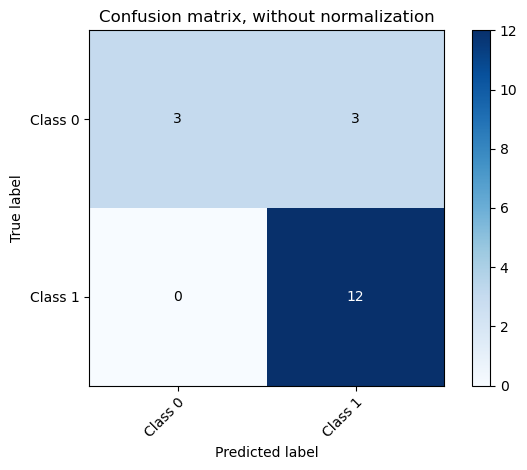

In [222]:
# Printing Out the Confusion Matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Printing Out the Confusion Matrix of the Logistic Regression Model
plot_confusion_matrix(Y_test, yhat, classes=["Class 0", "Class 1"])
plt.show()

#### Support Vector Machine

tuned hyperparameters (best parameters):  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy:  0.8482142857142856
Test accuracy of SVM: 0.8333333333333334
Confusion matrix, without normalization


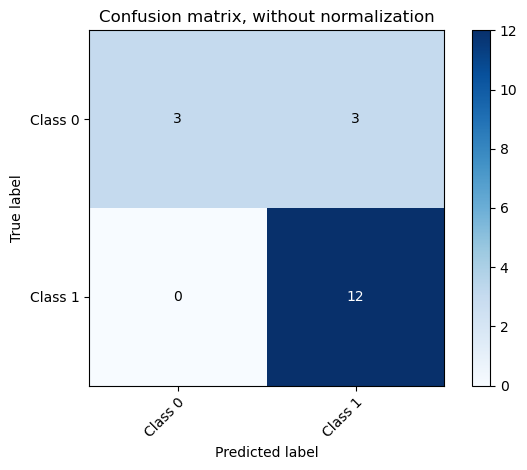

In [226]:
# Defining the Parameters for Grid Search
parameters = {'kernel':('linear', 'rbf','poly','sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}

# Creating an SVM object
svm = SVC()

# Creating a GridSearchCV object with 10-fold Cross-Validation
svm_cv = GridSearchCV(svm, parameters, cv=10)

# Fitting the GridSearchCV object to find the best Parameters
svm_cv.fit(X_train, Y_train)

# Printing the Best Parameters found
print("tuned hyperparameters (best parameters): ", svm_cv.best_params_)
print("accuracy: ", svm_cv.best_score_)

# Calculating the Accuracy of SVM on test data
accuracy = svm_cv.score(X_test, Y_test)
print("Test accuracy of SVM:", accuracy)

# Plotting the Confusion Matrix
yhat = svm_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat, classes=["Class 0", "Class 1"])
plt.show()

#### Decision Tree Classifier

tuned hyperparameters (best parameters):  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'splitter': 'random'}
accuracy:  0.8875
Test accuracy of Decision Tree Classifier: 0.8333333333333334
Confusion matrix, without normalization


/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
3240 fits failed out of a total of 6480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3240 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/Users/alijazibrizvi/anaconda3/lib/python3.11/site-packages/sklearn/base.py", line 637, in _validate_params
    validate_

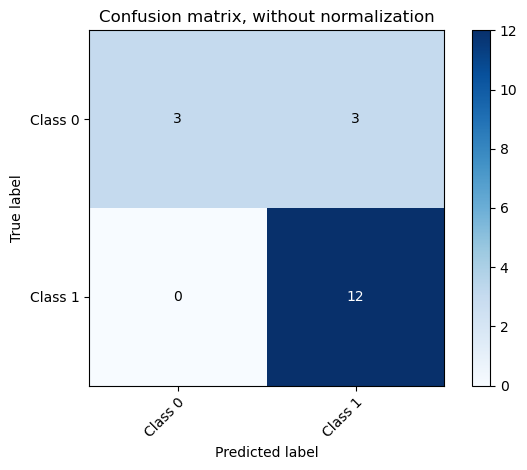

In [230]:
# Defining the Parameters for Grid Search
parameters = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': [2*n for n in range(1,10)],
              'max_features': ['auto', 'sqrt'],
              'min_samples_leaf': [1, 2, 4],
              'min_samples_split': [2, 5, 10]}

# Creating a Decision Tree Classifier object
tree = DecisionTreeClassifier()

# Creating a GridSearchCV object with 10-fold cross-validation
tree_cv = GridSearchCV(tree, parameters, cv=10)

# Fitting the GridSearchCV object to find the best parameters
tree_cv.fit(X_train, Y_train)

# Printing the best parameters found
print("tuned hyperparameters (best parameters): ", tree_cv.best_params_)
print("accuracy: ", tree_cv.best_score_)

# Calculating the accuracy of Decision Tree on test data
accuracy = tree_cv.score(X_test, Y_test)
print("Test accuracy of Decision Tree Classifier:", accuracy)

# Plotting the confusion matrix
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat, classes=["Class 0", "Class 1"])
plt.show()

#### K-Nearest Neighbors

tuned hyperparameters (best parameters):  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
Accuracy of KNN Model:  0.8482142857142858
Test accuracy: 0.8333333333333334
Confusion matrix, without normalization


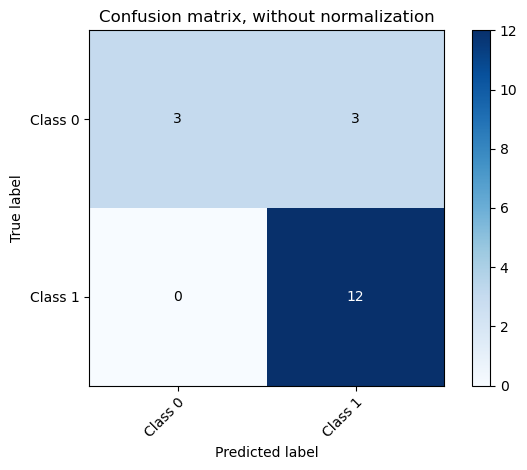

In [232]:
# Defining the Parameters for Grid Search
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

# Creating a KNN object
KNN = KNeighborsClassifier()

# Creating a GridSearchCV object with 10-fold cross-validation
knn_cv = GridSearchCV(KNN, parameters, cv=10)

# Fitting the GridSearchCV object to find the best parameters
knn_cv.fit(X_train, Y_train)

# Printing the Best Parameters found
print("tuned hyperparameters (best parameters): ", knn_cv.best_params_)
print("Accuracy of KNN Model: ", knn_cv.best_score_)

# Calculating the Accuracy of KNN on Test data
accuracy = knn_cv.score(X_test, Y_test)
print("Test accuracy:", accuracy)

# Plotting the Confusion Matrix
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test, yhat, classes=["Class 0", "Class 1"])
plt.show()

In [ ]:
# FINAL: ^To Determine Which Model Performed Best, You may Compare Each's "best_score_" or ".score"

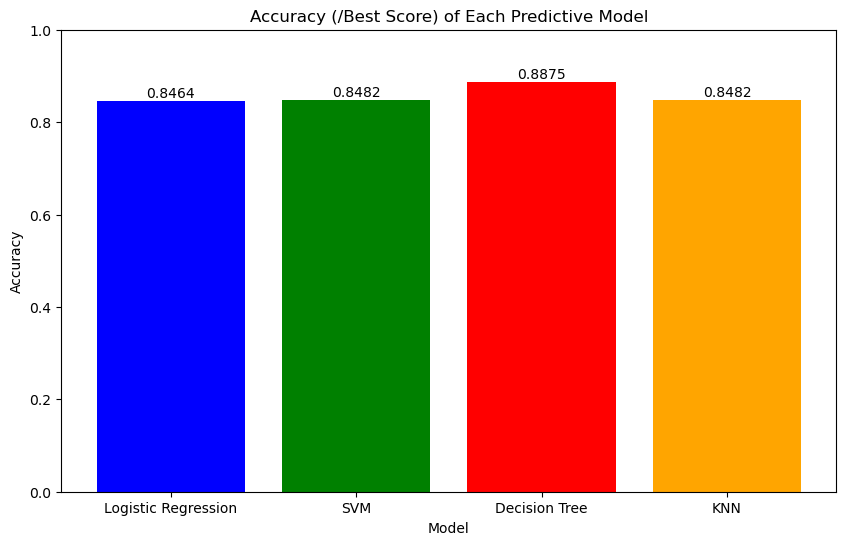

In [239]:
# Using a Bar Chart to Compare Each Model's Accuracy

# Define the Model names and their Corresponding Best Scores
models = ['Logistic Regression', 'SVM', 'Decision Tree', 'KNN']
best_scores = [logreg_cv.best_score_, svm_cv.best_score_, tree_cv.best_score_, knn_cv.best_score_]

# Plotting the Bar Chart
plt.figure(figsize=(10, 6))
bars = plt.bar(models, best_scores, color=['blue', 'green', 'red', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy (/Best Score) of Each Predictive Model')
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1 for better visualization of scores

# Adding text labels at the top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 4), ha='center', va='bottom')

plt.show()

## Data Findings Report

In [ ]:
# Begin with an OUTLINE of your Findings Report

# 1. Cover Page
## Title of Presentation
## Your Name
## Date

# 2. Executive Summary
## Should Briefly Explain the Details
## Considered a Standalone Document (Fine to Repeat Info; no New Info is Presented)


# 3. Table of Contents
## Sections of your Report
## Subsections of your Report (To Give Audience an Overview of the Contents)

# 4. Introduction
## Explains the Nature of the Analysis
## States the Problem
## Gives the Questions that were to be Answered by Performing the Analysis

# 5. Methodology
## Explains the Data Sources that were Used in the Analysis
## Outlines the Plan for the Collected Data (e.g., was the Cluster of Regression method used to Analyze the Data?)

# 6. Results
## Goes into Detail of the Data Collection
## Explains How Data was Organized
## Explains How Data was Analyzed
# (Steps: 1. Descriptive Statistics, 2. Illustrative Graphics, 3. Formally Testing your Hypothesis)
## Contains Charts and Graphs that would Substantiate the Results

# 7. Discussion
## Engage the Audience with a Discussion of your Implications that were Drawn from the Research

# 8. Conclusion
## Reiterate the Problem Given in the Introduction
## Gives an Overall Summary of the Findings
## States the Outcome of the Analysis & if Any Other Steps Would be Taken in the Future

# 9. Appendix
## Contains Info that didn't Fit in the Report but was Still Important Enough to Include
## (Details such as Acknowledgements, Resources, and References)


# General Tips:

## Use the Data ONLY AS Supporting Evidence
## Share ONLY ONE Point From Each Chart
## Eliminate Data that DOES NOT Support the Key Message


# Before Submitting, Try Answering these Questions to Review Your Writing:

## Have you told readers, at the outset, what they might gain by reading your paper?

## Have you made the aim of your work clear?

## Have you explained the significance of your contribution?

## Have you set your work in the appropriate context by giving sufficient background (including a complete set of relevant references) to your work?

## Have you addressed the question of practicality and usefulness?

## Have you identified future developments that might result from your work?

## Have you structured your paper in a clear and logical fashion?